In [201]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import History
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from scipy.stats import randint

### Summary: 

- This project aims to build neural network models to classify the resistance status of genes against a certain drug. The given dataset contains 100,000 gene sequences and their resistance (T/F). 

### Data preparation: 

- The DNA bases (characters) are converted to integers.
- The genes were padded to have equal lengths. 
- The resistance is one-hot encoded.

### Models in CNNandRNNwithoutCV.ipynb: 

- In a separate notebook, we built <b>model1 </b> which was a CNN with dropout layers. This model had an underfitting issue.

- In a separate notebook, we built <b> model2 </b> which was a CNN without dropouts. Although the hyperparameters were randomly chosen, this model produced the <b> best result (99.46% accuracy)</b>.

- In a separate notebook, we built <b> model3 </b> which was an RNN. We did not have a GPU, and we downsampled and worked with 20,000 data points.
- This initial build did not perform as well compared to CNN models. 
- We did not pursue this route further as the computation cost for RNNs is high. 

### Model in this notebook: 

- This notebook contains a CNN <b> model </b> which has two filter layers, two pooling layers, and one hidden layer. 
- We performed 5-fold cross-validation on the training set to find the best hyperparameters. 
- The hyperparameters are: the number of filters, the filter sizes (kernel sizes), the pooling size, the number of neurons in the hidden layer (units), and the optimizer. 
- With the best parameters, the <b> model </b> predicts the resistance with <b> 97.13% accuracy </b>.
- The 5-fold cv validation score is 95.28% which is not too far off from the test score of 97.13%. The validation score can be slightly lower than the test score since each fold sees different parts of data during cross-validation. The cv score is a better estimate how the model will perform for unseen data. 

In [2]:
# Read the data set
data = np.load("dataset.npy", allow_pickle=True).item()
xs = data["genes"] # [n_sample, arbitrary length string object]
ys = data["resistant"] # [n_sample, bool]

In [3]:
# Check the data size
xs.shape

(100000,)

In [4]:
# Check the first two entries of xs
xs[:2]

array(['ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTGAAGTTATTGAATGCGGCTTGGAAGTTAATTGCTTGGAACAGTCTCGTATTCAGATTTCTCCCGTTCGTCCCAAACGTCCCGCTCACAAAGCTAATATTATGTGGACTATTGACGACGCTTTCTTGCACAAACACAAAATTAATTGCGCTTCTTTCGACAATATTGACGCTGACTTCCGTCAGGACGCTTTCCAGCACAAACGTCGTTTGCCCTGGCACACTTACGAATTCCACCCCCGTATGGAACCCCACTGGTGCTTGCCCGGCAATAATTACATGCACGCTGCTTACCCCAAAGACCACGGCATTAAATTCGCTTGGTTGAATCGTAAATACACTACTTACAATCACTGCGACACTTTCACTACTACTTGCTGCTTCGCTGCTTGGTGCAATGGCGAAATGACTGGCTTCTACTGCGGCATGTCTTCTGCTAAAGGCTCTGACTACGAATGGGACTGGTACCACTACAAAGCTATTCACGTTATTGCTATGGTTTTGGACCACTCTTCTTACACTTGCGCTTCTAATTTCTTCAAAAAAGACTGGTCTTCTGACTACGCTTACATGACTATTGAAGGCATTTACGACTCTGACGTTCAGGTTTGCGACTCTAAAGAAGCTGAAGCTCAGTCTTACATTCACGACACTGCTTCTAATTGGCAGGGCGGCCCCTGGATTTGCGCTCGTGCTTTCTCTTGGGAAGACACTACTAATCAGGGCGACAAATTCACTCAGGACGCTTACGCTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAAT

In [5]:
# Check the first two entries of xs
ys[:2]

array([False, False])

In [ ]:
# Put the data into a Pandas dataframe so that we can apply functions 
df=pd.DataFrame({"Gene":xs, "Resistance":ys})
# Check if each gene has the same length 
df["Gene_length"]=df.Gene.apply(len)

In [9]:
df.Gene_length.value_counts().sort_index()

894     6426
895     3142
896     3100
897     6228
898     3053
899     3115
900    50011
901     3084
902     3200
903     6297
904     3129
905     3144
906     6071
Name: Gene_length, dtype: int64

In [10]:
# To put each gene as an input to CNN, the length of the genes must be the same.
# We pad the genes so that they all have length 906 which equals the longest gene sequence in the dataset.
# Q is a "dummy DNA base" that we use to fix the gene length.
df["Gene_padded"]=df.Gene.apply(lambda x : x.ljust(906,"Q"))

In [329]:
# Check the current dataframe
df.head()

,Gene,Resistance,Gene_length,Gene_padded
0,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,False,900,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
1,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,False,897,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,False,900,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
3,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,False,900,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
4,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,True,904,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...


In [94]:
# We cannot work with strings of characters. 
# We define a dictionary that translates each DNA base (plus a dummy base Q) to a number. 
char_to_int={"A": 0, "C": 1, "G":2, "T":3, "Q":4} 
def geneint(word):
    return np.array([char_to_int[char] for char in word])
gene_int=df.Gene_padded.apply(geneint)
gene_int[:5]

0    [0, 3, 2, 1, 0, 1, 3, 0, 1, 1, 2, 3, 0, 3, 2, ...
1    [0, 3, 2, 1, 0, 1, 3, 0, 1, 1, 2, 3, 0, 3, 2, ...
2    [0, 3, 2, 1, 0, 1, 3, 0, 1, 1, 2, 3, 0, 3, 2, ...
3    [0, 3, 2, 1, 0, 1, 3, 0, 1, 1, 2, 3, 0, 3, 2, ...
4    [0, 3, 2, 1, 0, 1, 3, 0, 1, 1, 2, 3, 0, 3, 2, ...
Name: Gene_padded, dtype: object

In [330]:
# We one-hot encode the resistance column
resistance_int=to_categorical(df.Resistance)
resistance_int[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [333]:
# Reshaping each row to have 906 length-one vectors. 
x_input=np.stack(gene_int.values)
x_input.shape

(100000, 906)

In [143]:
# Making a 80%-20% train-test split.
x_train, x_test, y_train, y_test = train_test_split(x_input.reshape(100000,906,1), np.asarray(resistance_int).reshape(100000,2), 
                                                    test_size=0.2, shuffle= True)


In [ ]:
# 5-fold cross-validation using RandomizedSearchCV from sklearn.
# This requires a wrapper for the model. 

def create_model(filters1=5,filters2=10, kernel_size1=3, kernel_size2=3,units=32,optimizer="adam",
                     pool_size=2,activation="relu"):
    model = Sequential()
    model.add(Conv1D(filters=filters1, kernel_size=kernel_size1, activation= activation, input_shape=(906,1)))
    model.add(MaxPool1D(pool_size=pool_size))
    model.add(Conv1D(filters=filters2, kernel_size=kernel_size2, activation= activation, input_shape=(906,1)))
    model.add(MaxPool1D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(units=units, activation="relu"))
    model.add(Dense(2, activation="softmax"))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


cv_model = KerasClassifier(build_fn=create_model) 



# Perform the randomized search. 
# We try 10 different sets of parameter values. 
rs_model = RandomizedSearchCV( 
    cv_model,
    param_distributions = {"filters1":randint(5,10), 
                           "filters2":randint(5,20),
                           "kernel_size1":randint(2,10),
                           "kernel_size2":randint(2,10),
                           "units":[16,32,64],
                           "optimizer":["adam", "nadam", "RMSprop", "SGD"],
                          "pool_size":randint(2,10)},
    #scoring = 'accuracy',
    n_iter = 10, 
    n_jobs= 1,
    cv = 5,
    random_state=42
)
rs_model.fit(x_train, y_train, epochs=20)

In [316]:
# Print the cross-validation result in a table 
pd.DataFrame(rs_model.cv_results_)[["rank_test_score","mean_test_score", "std_test_score","param_filters1","param_kernel_size1","param_filters2",  "param_kernel_size2", "param_pool_size", "param_units","param_optimizer"]].sort_values("rank_test_score")

,rank_test_score,mean_test_score,std_test_score,param_filters1,param_kernel_size1,param_filters2,param_kernel_size2,param_pool_size,param_units,param_optimizer
2,1,0.952800,0.029228,8,9,12,4,6,32,nadam
7,2,0.931325,0.042086,9,8,7,6,8,32,adam
4,3,0.912512,0.079763,5,3,16,7,5,16,adam
0,4,0.906438,0.053841,8,8,17,4,6,16,SGD
5,5,0.889413,0.028177,5,4,15,8,9,64,nadam
6,6,0.883850,0.060448,7,8,16,5,2,64,SGD
1,7,0.879150,0.034675,6,8,7,4,9,16,RMSprop
3,8,0.878838,0.054691,8,7,18,3,5,16,SGD
8,9,0.846037,0.120141,8,5,13,7,3,16,nadam
9,10,0.840225,0.023855,6,3,9,5,8,64,SGD


In [308]:
# Print the best parameters

print('Parameters:')
for param, value in rs_model.best_params_.items():
    print('\t{}: {}'.format(param, value))

Best score obtained: 0.9528
Parameters:
	filters1: 8
	filters2: 12
	kernel_size1: 9
	kernel_size2: 4
	optimizer: nadam
	pool_size: 6
	units: 32


In [324]:
# Build a model using the best parameters
model = Sequential()
model.add(Conv1D(filters=8, kernel_size=9, activation="relu", input_shape=(906,1)))
model.add(MaxPool1D(pool_size=6))
model.add(Conv1D(filters=12, kernel_size=4, activation="relu", input_shape=(906,1)))
model.add(MaxPool1D(pool_size=6))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))
model.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['accuracy'])

In [319]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_192 (Conv1D)          (None, 898, 8)            80        
_________________________________________________________________
max_pooling1d_186 (MaxPoolin (None, 149, 8)            0         
_________________________________________________________________
conv1d_193 (Conv1D)          (None, 146, 12)           396       
_________________________________________________________________
max_pooling1d_187 (MaxPoolin (None, 24, 12)            0         
_________________________________________________________________
flatten_128 (Flatten)        (None, 288)               0         
_________________________________________________________________
dense_194 (Dense)            (None, 32)                9248      
_________________________________________________________________
dense_195 (Dense)            (None, 2)                 66        
Total para

In [ ]:
early=EarlyStopping(patience=3)
history=model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, callbacks=[early])

In [334]:
print(history.history["val_acc"])

[0.77625, 0.84695, 0.93885, 0.877, 0.94885, 0.87795, 0.9591, 0.95995, 0.9618, 0.9194, 0.96775, 0.88555, 0.97095, 0.9756, 0.9719, 0.9754, 0.97125, 0.97605, 0.9803, 0.9414, 0.97575, 0.9713]


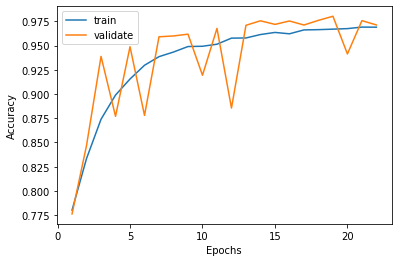

In [326]:
plt.plot(range(1,23),history.history["acc"], label="train")
plt.plot(range(1,23),history.history["val_acc"], label="validate")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [335]:
scores=model.evaluate(x_test, y_test)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

20000/20000 [==============================] - 5s 237us/step
acc: 97.13%
